# Hipótesis 15  
El uso de la función de costo denominada "focal loss" permite mejorar el desempeño de la red en problemas de clasificación desbalanceados.

**Integrantes**
> Mario Mallea, Maximiliano Ramírez, Hugo Rocha.

**Dataset:**
> Fraude https://www.kaggle.com/mlg-ulb/creditcardfraud

> Diabetes https://www.kaggle.com/uciml/pima-indians-diabetes-database

# Focal Loss

Metodología: Para dos bases de datos desbalanceadas se estudiará el desempeño del modelo, a través de la métrica recall de la clase minoritaria con un modelo neuronal de clasificación con aquitectura fija, entrenado con las funciones de pérdida CrossEntropy y Focal Loss.

<table align='left'>
<tr>
<td><img src='https://miro.medium.com/max/606/1*qd7u4PjpaKgO-pUX8vi7XQ.png' width='750'/> </td>
</tr>
</table>

fuente: Focal Loss for Dense Object Detection. https://arxiv.org/pdf/1708.02002.pdf

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
import pydot
from keras.models import Sequential
from keras.layers import Dense
#import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers
from sklearn.metrics import recall_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from numpy.random import seed
import random as python_random
import random
from random import randint

from sklearn import metrics
from sklearn.metrics import accuracy_score

seed(0)
python_random.seed(0)
tf.random.set_seed(0) # P</span></span>ara semilla 42 catogorical crossentropy es mejor que focal loss
                      # Para semilla 0 catogorical crossentropy es mejor que focal loss

plt.figure(figsize=(20,20))

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

# Fraude Crediticio <1%

Credit fraud es un dataset que contiene transacciones que fueron realizadas con tarjetas de crédito, con historial desde septiembre del 2013 cuyos titulares provienen de europa. El conjunto de datos cuenta con transacciones que fueron realizadas durante 2 días, donde se tiene un <span class="mark">total de $284.807$ operaciones de las cuales 492 corresponden a fraude</span>, mientras que el resto corresponden a la clase mayoritaria, no fraude.

El dataset debido a problemas de confidencialidad no cuenta con el nombre de las columnas utilizadas para la predicción. Por lo que las columnas son representadas con nombres genéricos "V1, V2, ..., V28", las cuales fueron obtenidas mediante PCA. Además contamos con la columna **Time**, que cuenta los segundos entre cada transacción, sim embargo no es utilizada para efectos de este trabajo. Además se cuenta con la columna **Amount**, la cual da cuenta del importe de la transacción.

Finalmente las etiquetas o clases de este problema vienen dadas por 1 en caso de fraude, y 0 en caso contrario.



<table align='left'>
<tr>
<td><img src='https://aristeguinoticias.com/editorial/wp-content/uploads/2019/11/fraude-financiero-victimas-16112019.jpg' width='750'/> </td>
</tr>
</table>

In [2]:
credit_df= pd.read_csv('creditcard.csv')

In [3]:
credit_df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


## Análisis exploratorio de datos

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')


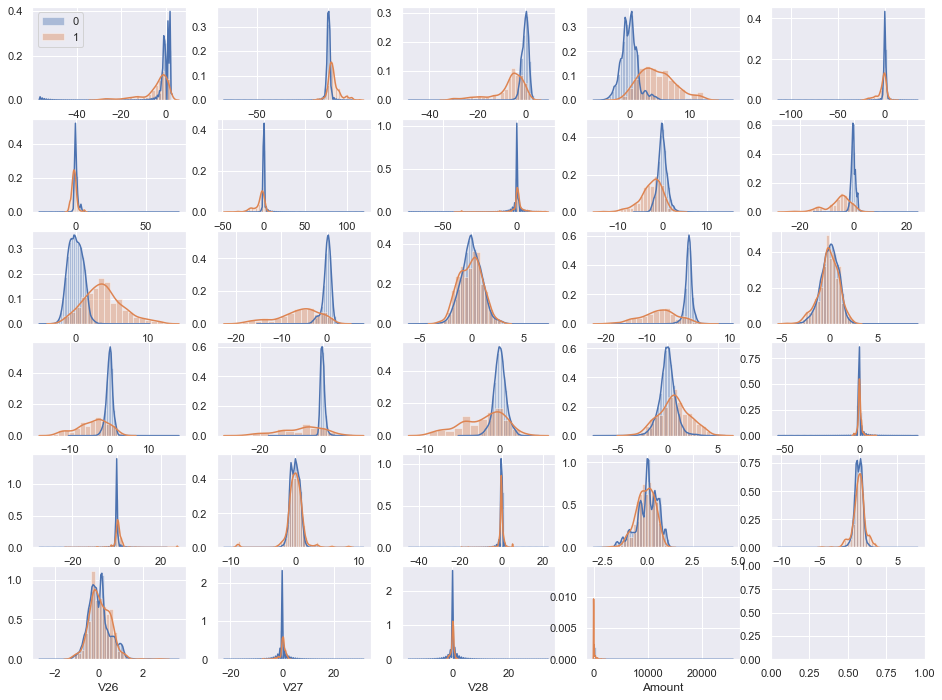

In [4]:
print(credit_df.columns[1:-1])

cont_predictors_names = credit_df.columns[1:-1] #atributo continuo

categorias = [0, 1]
#dummies = pd.get_dummies(df['Category'])

fig, axes = plt.subplots(figsize=(16,12), nrows=6, ncols=5)
for i, column in enumerate(cont_predictors_names):
    for genre in categorias:
        target = credit_df.loc[credit_df['Class'] == genre]
        sns.distplot(target[column], hist=True, rug=False, kde=True, ax=axes[i//5,i%5],label=genre)
        if i==0:
            axes[0,0].legend()

plt.show()

In [4]:
print ('real cases:', len(credit_df[credit_df['Class']==0]))
print ('fraud cases: ', len(credit_df[credit_df['Class']==1]))

real cases: 284315
fraud cases:  492


## Pre procesamiento

In [3]:
robust_scaler =RobustScaler()

credit_df[['Amount']] = robust_scaler.fit_transform(credit_df[['Amount']]) 

X_labels = credit_df.drop(['Class', 'Time'], axis=1)
y_labels = credit_df['Class']
X_labels = X_labels.to_numpy(dtype=np.float64)
y_lab_cat= pd.get_dummies(y_labels)

#y_labels = y_labels.to_numpy(dtype=np.float64)

#y_lab_cat = tf.keras.utils.to_categorical(y_labels, num_classes=2, dtype='float32')

#split que mantiene proporcion entre ambas clases
x_train, x_test, y_train, y_test, train_ind, test_ind = train_test_split(X_labels, y_lab_cat, credit_df.index , test_size=0.3, stratify=y_lab_cat, random_state=42)

y_testt = y_labels.iloc[test_ind]

y_train= y_train.to_numpy(dtype=np.float64)

**función que permite definir la arquitectura de la red**

In [4]:
def ite_model():
    model1 = Sequential()
    model1.add(Dense(64, input_dim = (x_train.shape[1]), activation = 'relu'))
    model1.add(Dense(32, activation = 'relu'))
    model1.add(Dense(2, activation = 'softmax'))
    
    return model1

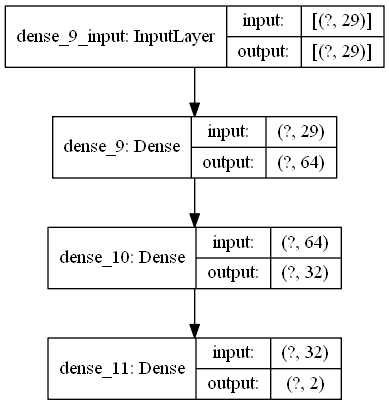

In [20]:
keras.utils.plot_model(ite_model(), show_shapes=True)
#ite_model().summary()

**función que permite <span class="girk">evaluar</span> el modelo en distintas semillas, para finalmente promediar y obtener resultados más representativos**

In [5]:
def score(n, loss, data,bs):
    suma=0
    recalls = []
    for i in range(n):
        seed(i)
        python_random.seed(i)
        tf.random.set_seed(i)
        
        model= ite_model()
        model.compile(optimizer='SGD', loss=loss, metrics=['acc'])
        
        #Fit
        model.fit(x_train, y_train, epochs=10, batch_size=bs, verbose=0)
        
        #predicciones
        y_pred = model.predict(x_test)
        y_pred = np.argmax(y_pred, axis=1)
        recall=recall_score(data.loc[list(y_test.index), data.columns[-1]], y_pred, average='binary', pos_label= 1)
        recalls.append(recall)
        suma+=recall
        
        
    return suma/n, recalls

## Comparación Loss

### Modelo con crossentropy (instancia para semilla cualquiera)

In [6]:
model1 = ite_model()
 
model1.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['acc'])

#Fit
history = model1.fit(x_train, y_train, validation_data= (x_test, y_test), epochs=50, batch_size=256)

#predicciones
y_pred = model1.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

#Matriz de Confusión + Report
confusion_matrix(credit_df.loc[list(y_test.index), "Class"], y_pred)


Epoch 1/50
779/779 [==============================] - 1s 906us/step - loss: 0.0475 - acc: 0.9968 - val_loss: 0.0128 - val_acc: 0.9985
Epoch 2/50
779/779 [==============================] - 1s 775us/step - loss: 0.0101 - acc: 0.9988 - val_loss: 0.0082 - val_acc: 0.9989
Epoch 3/50
779/779 [==============================] - 1s 770us/step - loss: 0.0075 - acc: 0.9990 - val_loss: 0.0066 - val_acc: 0.9990
Epoch 4/50
779/779 [==============================] - 1s 814us/step - loss: 0.0063 - acc: 0.9991 - val_loss: 0.0058 - val_acc: 0.9991
Epoch 5/50
779/779 [==============================] - 1s 777us/step - loss: 0.0057 - acc: 0.9992 - val_loss: 0.0053 - val_acc: 0.9992
Epoch 6/50
779/779 [==============================] - 1s 771us/step - loss: 0.0053 - acc: 0.9993 - val_loss: 0.0049 - val_acc: 0.9992
Epoch 7/50
779/779 [==============================] - 1s 784us/step - loss: 0.0049 - acc: 0.9993 - val_loss: 0.0047 - val_acc: 0.9992
Epoch 8/50
779/779 [==============================] - 1s 772us

array([[85277,    18],
       [   35,   113]], dtype=int64)

In [7]:
print(classification_report(credit_df.loc[list(y_test.index), "Class"], y_pred, target_names=['Real', 'Fraude']))

              precision    recall  f1-score   support

        Real       1.00      1.00      1.00     85295
      Fraude       0.86      0.76      0.81       148

    accuracy                           1.00     85443
   macro avg       0.93      0.88      0.90     85443
weighted avg       1.00      1.00      1.00     85443



### Curva Roc Crossentropy loss

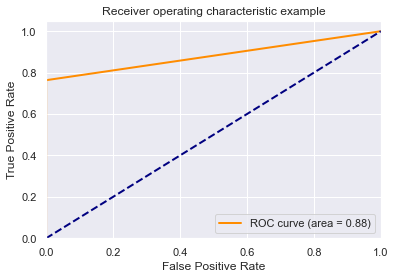

In [8]:
fpr, tpr, thresholds = metrics.roc_curve(y_testt, y_pred)

# Compute ROC curve and ROC area for each class
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Curva de aprendizaje Crossentropy loss

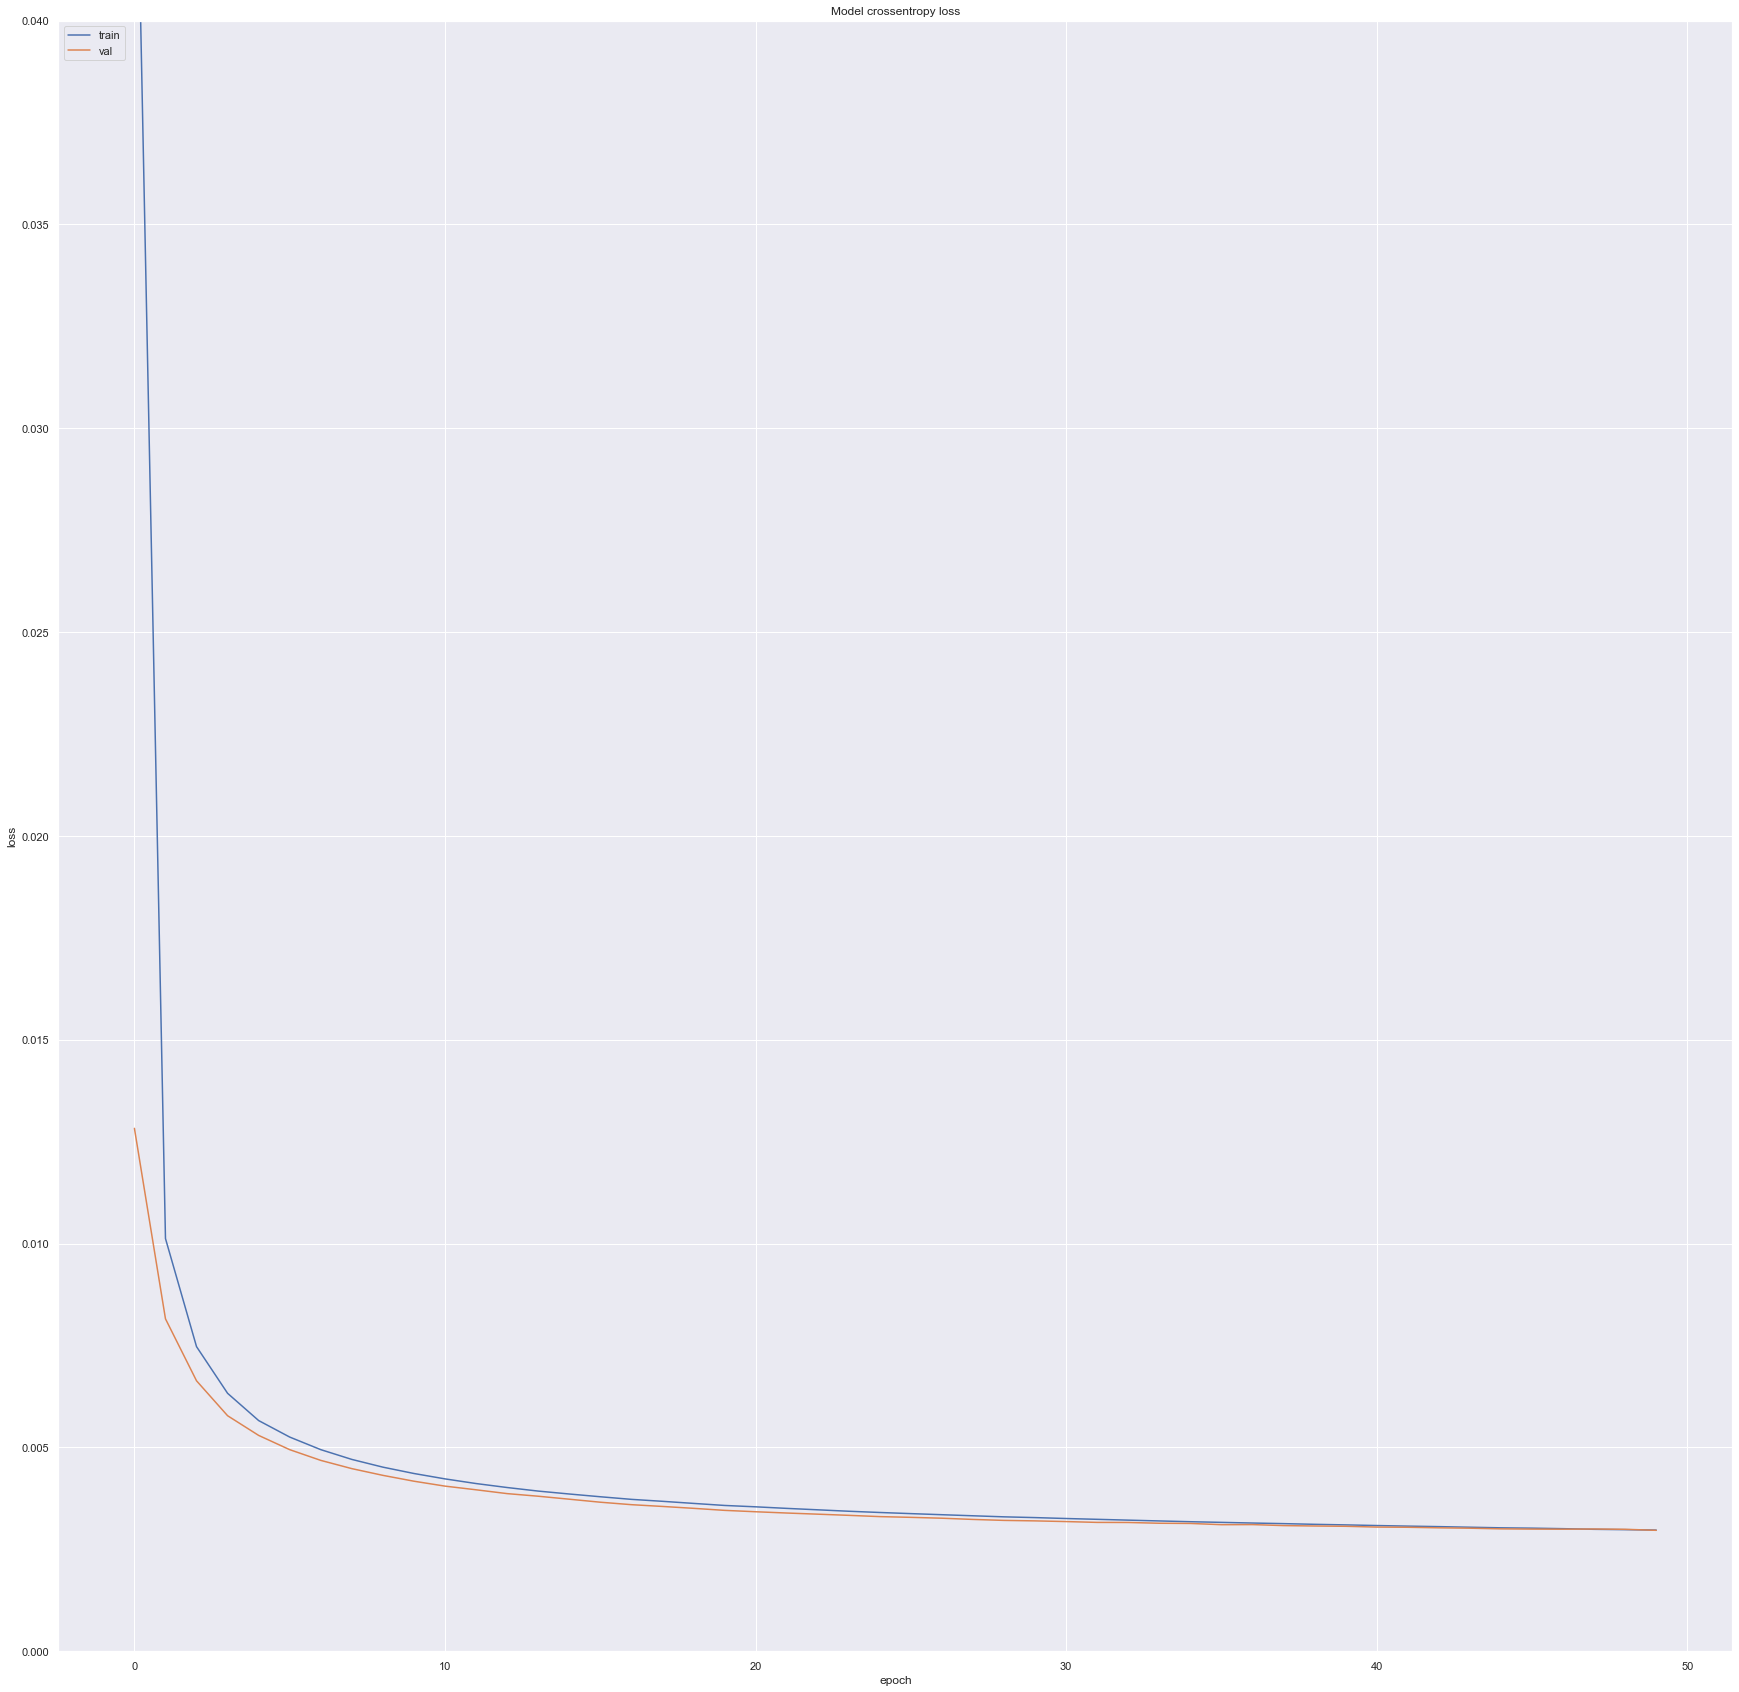

In [9]:
plt.figure(figsize=(30,30))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model crossentropy loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.ylim(0,0.04)
plt.show()

### Modelo con focal loss (Instancia para semilla cualquiera)

**Cross-validation**

In [49]:
%%time

random.seed(42)
alphas= [0.2, 0.5, 0.75]
gammas= [2,3,4,5]
lista= []
maximo=0
c=0
for a in alphas:
    for g in gammas:
        print(a,g)
        score_ite, l= score(20,tfa.losses.SigmoidFocalCrossEntropy(alpha= float(a), gamma= float(g)), credit_df,256)
        lista.append((score_ite,a,g))
        if score_ite >= maximo:
            maximo= score_ite
            max_c=c
        c+=1

0.2 2
0.2 3
0.2 4
0.2 5
0.5 2
0.5 3
0.5 4
0.5 5
0.75 2
0.75 3
0.75 4
0.75 5
Wall time: 25min 5s


In [50]:
mejor_a= lista[max_c][1]
mejor_g= lista[max_c][2]

print('El mejor alpha es : ', mejor_a)
print('El mejor gamma es : ', mejor_g)

El mejor alpha es :  0.75
El mejor gamma es :  5


In [51]:
model1 = ite_model()
 
model1.compile(optimizer='SGD', loss=tfa.losses.SigmoidFocalCrossEntropy(alpha= float(0.75), gamma= float(5.0)), metrics=['acc'])

#Fit
history = model1.fit(x_train, y_train, validation_data= (x_test, y_test.to_numpy('float64')), epochs=50, batch_size=256)

#predicciones
y_pred = model1.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

#Matriz de Confusión + Report
confusion_matrix(credit_df.loc[list(y_test.index), "Class"], y_pred)

Epoch 1/50
779/779 [==============================] - 1s 1ms/step - loss: 0.0011 - acc: 0.9986 - val_loss: 2.7411e-04 - val_acc: 0.9986
Epoch 2/50
779/779 [==============================] - 1s 973us/step - loss: 2.5964e-04 - acc: 0.9990 - val_loss: 2.3455e-04 - val_acc: 0.9990
Epoch 3/50
779/779 [==============================] - 1s 974us/step - loss: 2.1248e-04 - acc: 0.9990 - val_loss: 2.1944e-04 - val_acc: 0.9988
Epoch 4/50
779/779 [==============================] - 1s 960us/step - loss: 1.7591e-04 - acc: 0.9992 - val_loss: 1.9549e-04 - val_acc: 0.9993
Epoch 5/50
779/779 [==============================] - 1s 953us/step - loss: 1.6613e-04 - acc: 0.9993 - val_loss: 2.0897e-04 - val_acc: 0.9993
Epoch 6/50
779/779 [==============================] - 1s 962us/step - loss: 1.5817e-04 - acc: 0.9993 - val_loss: 1.8426e-04 - val_acc: 0.9992
Epoch 7/50
779/779 [==============================] - 1s 949us/step - loss: 1.3334e-04 - acc: 0.9993 - val_loss: 2.0631e-04 - val_acc: 0.9993
Epoch 8/50
7

array([[85287,     8],
       [   33,   115]], dtype=int64)

In [52]:
print(classification_report(credit_df.loc[list(y_test.index), "Class"], y_pred, target_names=['Real', 'Fraude']))

              precision    recall  f1-score   support

        Real       1.00      1.00      1.00     85295
      Fraude       0.93      0.78      0.85       148

    accuracy                           1.00     85443
   macro avg       0.97      0.89      0.92     85443
weighted avg       1.00      1.00      1.00     85443



### Curva Roc Focal loss

<Figure size 2160x2160 with 0 Axes>

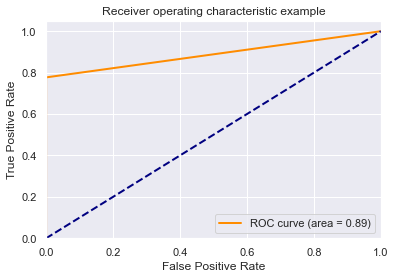

In [53]:
plt.figure(figsize=(30,30))

fpr, tpr, thresholds = metrics.roc_curve(y_testt, y_pred)

# Compute ROC curve and ROC area for each class
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Curva de aprendizaje Focal loss

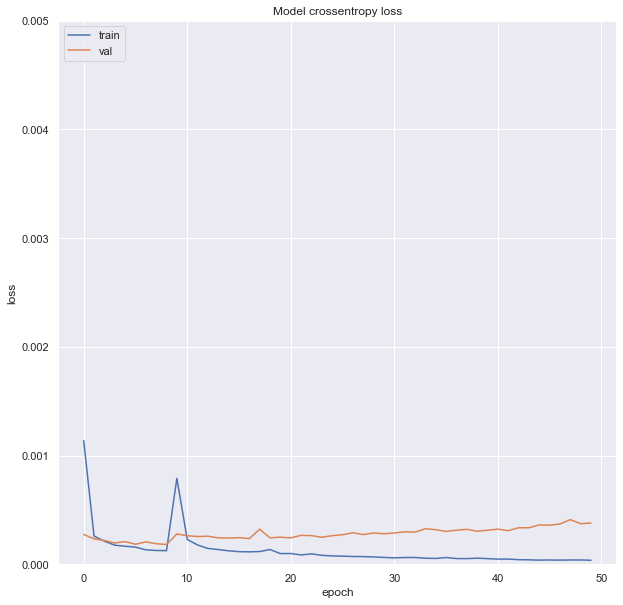

In [54]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model crossentropy loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.ylim(0,0.005)
plt.show()

**Función que permite graficar la métrica de interés para distintas semillas en los modelos escogidos**

In [55]:
def graficar(alpha, gamma, data,bs):
    prom_focal, lis_prom_focal = score(50 , tfa.losses.SigmoidFocalCrossEntropy(alpha= float(alpha), gamma= float(gamma)), data,bs)
    prom_ce, lis_prom_ce = score(50 , 'categorical_crossentropy', data,bs)
    
    dat= pd.DataFrame(columns=['n', 'Focal', 'Crossentropy'])
    
    for i in range(10):
         dat.loc[i] = [i*5, np.mean(lis_prom_focal[0:5*i]), np.mean(lis_prom_ce[0:5*i])]
    
    # tamano del grafico
    fig = plt.figure(figsize=(10, 5)) 
    for i in range(1,3):
        plt.plot(
        dat['n'],# eje x
        dat.iloc[:,i], # eje y
        label=dat.columns[i], # etiquetado
        linewidth=1 # tamano de la curva
        )

    plt.legend() # agregar etiquetado
    plt.title("Performance Crossentropy Loss vs Focal loss") # agregar titulo
    plt.xlabel("numero de semillas distintas") # nombre eje x
    plt.ylabel("Recall") # nombre eje y
    plt.grid() # agregar grillado
    plt.show() # mostrar grafico

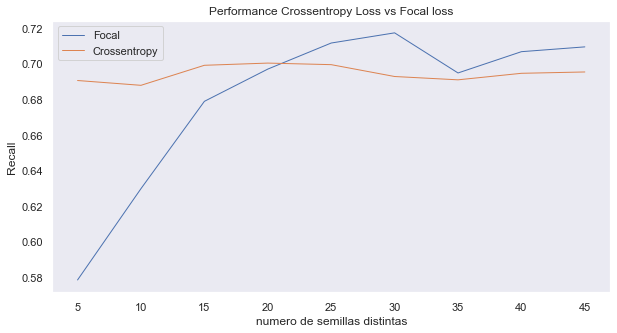

In [56]:
graficar(0.75, 5, credit_df,256)

# Diabetes 50%

Conjunto de datos es originalmente del Instituto Nacional de Diabetes y Enfermedades Digestivas y Renales. Tiene como objetivo la detección de la diabetes en mujeres provenientes de la india, mayores de 21 años, a partir de mediciones diagnósticas típicas.

Dentro de las variables predictoras podemos encontrar el número de embarazos que ha tenido la paciente, su IMC, nivel de insulina, edad, entre otras.

El dataset cuenta <span class="mark">con $268$ casos de diabetes, mientras que $500$ representan la clase contraria.</span>

La etiqueta se encuentra en la columna **Outcome**, donde 1 es la etiqueta para la clase diabetes, mientras que 0 representa la clase no diabetes.

<table align='left'>
<tr>
<td><img src='https://image.freepik.com/vector-gratis/paciente-diabetes-monitor-medidor-glucosa-sangre-resultado-prueba-caracter-plano-publicidad-medica_1284-28999.jpg' width='500'/> </td>
</tr>
</table>

In [11]:
diabetes = pd.read_csv('diabetes.csv')
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [27]:
print ('Diabetes:', len(diabetes[diabetes['Outcome']==1]))
print ('No diabetes: ', len(diabetes[diabetes['Outcome']==0]))

Diabetes: 268
No diabetes:  500


## Análisis exploratorio de datos

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')


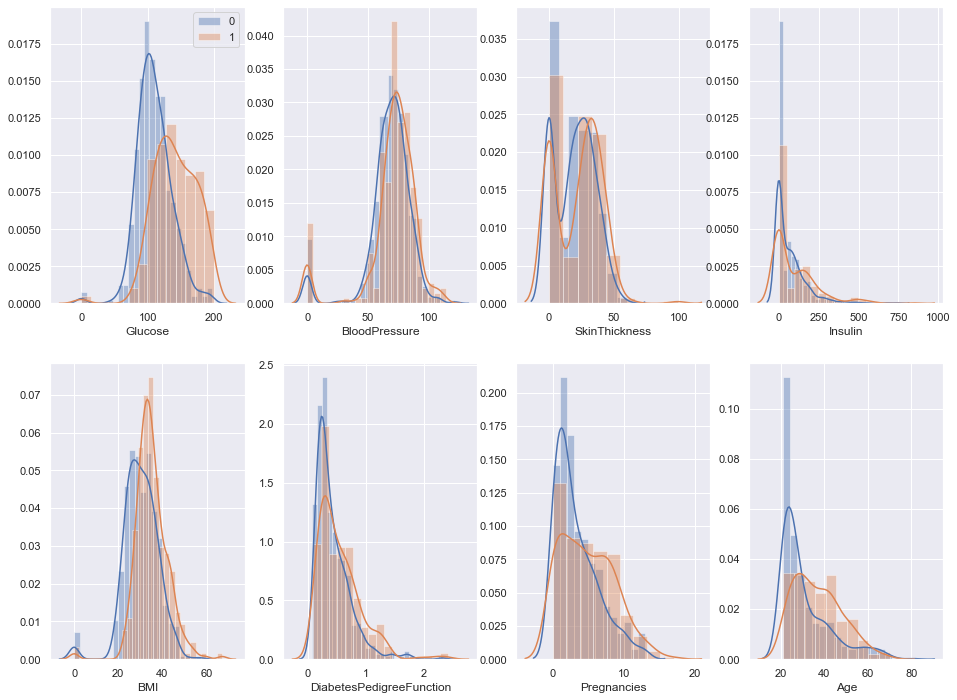

In [28]:
print(diabetes.columns)

cont_predictors_names = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Pregnancies','Age'] #atributo continuo

categorias = [0, 1]
#dummies = pd.get_dummies(df['Category'])

fig, axes = plt.subplots(figsize=(16,12), nrows=2, ncols=4)
for i, column in enumerate(cont_predictors_names):
    for genre in categorias:
        target = diabetes.loc[diabetes['Outcome'] == genre]
        sns.distplot(target[column], hist=True, rug=False, kde=True, ax=axes[i//4,i%4],label=genre)
        if i==0:
            axes[0,0].legend()

plt.show()


## Pre procesamiento

In [12]:
X = diabetes.drop('Outcome', axis=1)
y_labels = diabetes['Outcome']
y_lab_cat= pd.get_dummies(y_labels)

#Division de la data
x_train, x_test, y_train, y_test, train_ind, test_ind  = train_test_split(X, y_lab_cat, diabetes.index ,test_size=0.2, stratify=y_lab_cat, random_state=42)

#Escalamiento

scaler = StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_testt = y_labels.iloc[test_ind]

y_train= y_train.to_numpy(dtype=np.float64)

## Comparación Loss

### Modelo con crossentropy (Instancia para semilla cualquiera)

In [13]:
model1 = ite_model()
 
model1.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['acc'])

#Fit
history = model1.fit(x_train, y_train, validation_data= (x_test, y_test), epochs=50, batch_size=32)

#predicciones
y_pred = model1.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

#Matriz de Confusión + Report
confusion_matrix(diabetes.loc[list(y_test.index), "Outcome"], y_pred)

Epoch 1/50
20/20 [==============================] - 0s 6ms/step - loss: 0.6496 - acc: 0.6824 - val_loss: 0.6488 - val_acc: 0.6948
Epoch 2/50
20/20 [==============================] - 0s 1ms/step - loss: 0.6258 - acc: 0.7280 - val_loss: 0.6295 - val_acc: 0.7078
Epoch 3/50
20/20 [==============================] - 0s 1ms/step - loss: 0.6064 - acc: 0.7264 - val_loss: 0.6142 - val_acc: 0.7013
Epoch 4/50
20/20 [==============================] - 0s 1ms/step - loss: 0.5912 - acc: 0.7264 - val_loss: 0.6018 - val_acc: 0.7013
Epoch 5/50
20/20 [==============================] - 0s 1ms/step - loss: 0.5787 - acc: 0.7394 - val_loss: 0.5900 - val_acc: 0.7013
Epoch 6/50
20/20 [==============================] - 0s 1ms/step - loss: 0.5670 - acc: 0.7492 - val_loss: 0.5791 - val_acc: 0.7013
Epoch 7/50
20/20 [==============================] - 0s 1ms/step - loss: 0.5564 - acc: 0.7573 - val_loss: 0.5684 - val_acc: 0.7143
Epoch 8/50
20/20 [==============================] - 0s 1ms/step - loss: 0.5458 - acc: 0.75

array([[87, 13],
       [21, 33]], dtype=int64)

In [14]:
print(classification_report(diabetes.loc[list(y_test.index), "Outcome"], y_pred, target_names=['No diabetes', 'Diabetes']))

              precision    recall  f1-score   support

 No diabetes       0.81      0.87      0.84       100
    Diabetes       0.72      0.61      0.66        54

    accuracy                           0.78       154
   macro avg       0.76      0.74      0.75       154
weighted avg       0.77      0.78      0.77       154



### Curva Roc Crossentropy loss

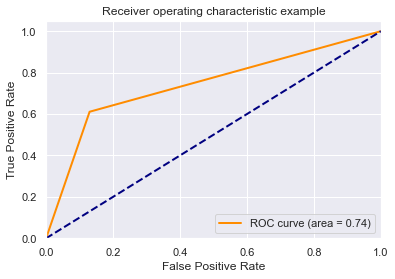

In [15]:
fpr, tpr, thresholds = metrics.roc_curve(y_testt, y_pred)

# Compute ROC curve and ROC area for each class
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Curva de aprendizaje Crossentropy loss

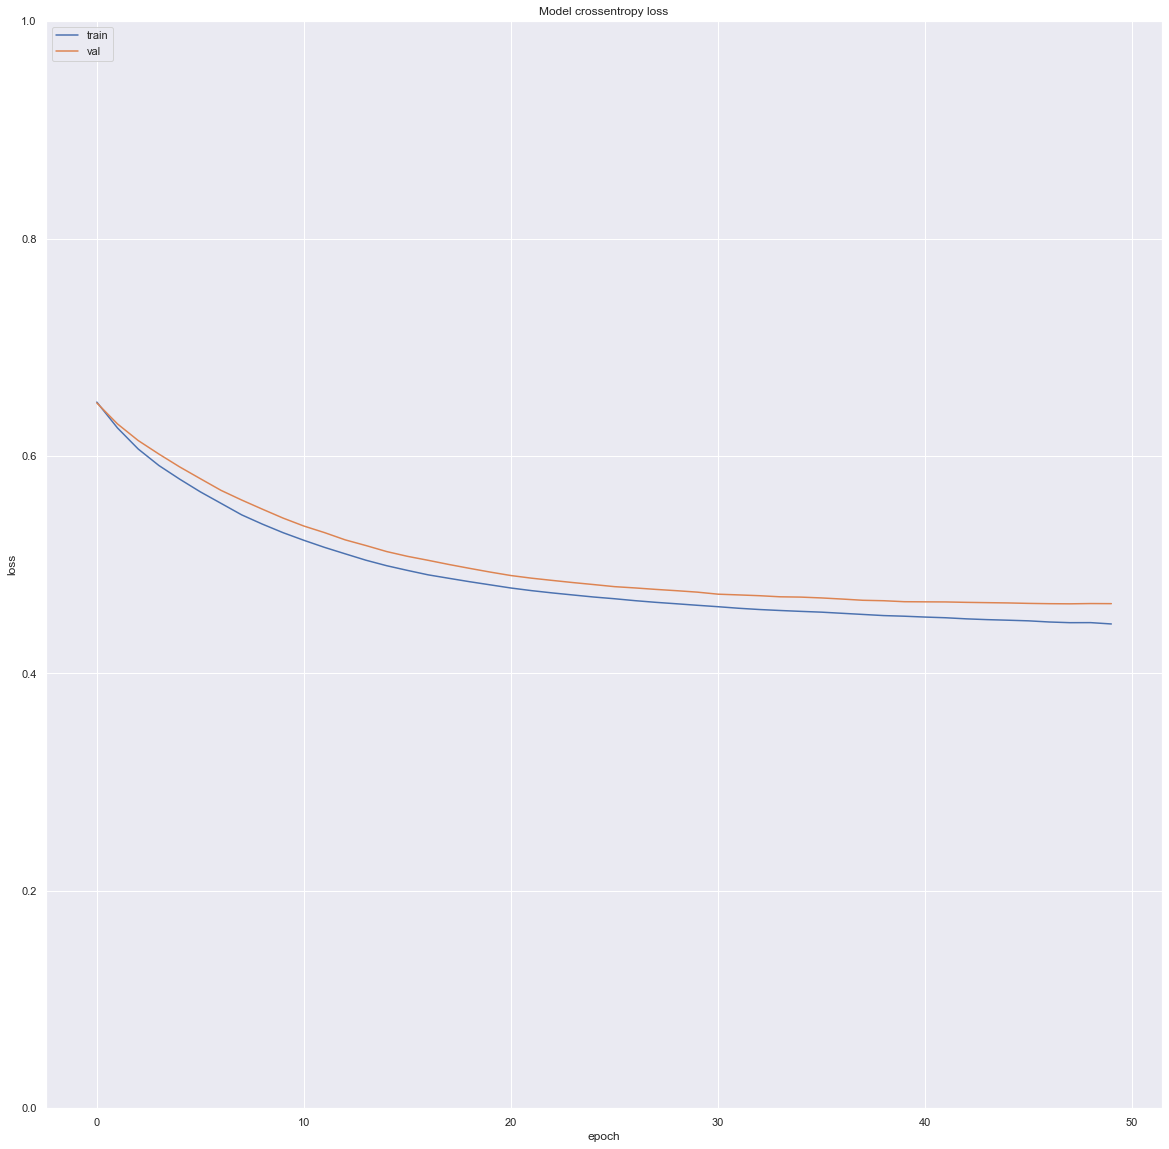

In [16]:
plt.figure(figsize=(20,20))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model crossentropy loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.ylim(0,1)
plt.show()

### Modelo con focal loss (Instancia para una semilla cualquiera)

CV

In [34]:
%%time

random.seed(42)
alphas= [0.2, 0.25, 0.75]
gammas= [2,3,4,5]
lista= []
maximo=0
c=0
for a in alphas:
    for g in gammas:
        print(a,g)
        score_ite, l = score(10,tfa.losses.SigmoidFocalCrossEntropy(alpha= float(a), gamma= float(g)), diabetes,32)
        lista.append((score_ite,a,g))
        if score_ite >= maximo:
            maximo= score_ite
            max_c=c
        c+=1

0.2 2
0.2 3
0.2 4
0.2 5
0.25 2
0.25 3
0.25 4
0.25 5
0.75 2
0.75 3
0.75 4
0.75 5
Wall time: 50.6 s


In [35]:
mejor_a= lista[max_c][1]
mejor_g= lista[max_c][2]

print('El mejor alpha es : ', mejor_a)
print('El mejor gamma es : ', mejor_g)

El mejor alpha es :  0.75
El mejor gamma es :  3


In [17]:
model1 = ite_model()
 
model1.compile(optimizer='SGD', loss=tfa.losses.SigmoidFocalCrossEntropy(alpha= float(0.75), gamma= float(3)), metrics=['acc'])

#Fit
history = model1.fit(x_train, y_train, validation_data= (x_test, y_test.to_numpy('float64')), epochs=50, batch_size=32)

#predicciones
y_pred = model1.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

#Matriz de Confusión + Report
confusion_matrix(diabetes.loc[list(y_test.index), "Outcome"], y_pred)

Epoch 1/50
20/20 [==============================] - 0s 5ms/step - loss: 0.0760 - acc: 0.6824 - val_loss: 0.0636 - val_acc: 0.7468
Epoch 2/50
20/20 [==============================] - 0s 1ms/step - loss: 0.0627 - acc: 0.7720 - val_loss: 0.0642 - val_acc: 0.7532
Epoch 3/50
20/20 [==============================] - 0s 1ms/step - loss: 0.0614 - acc: 0.7720 - val_loss: 0.0628 - val_acc: 0.7468
Epoch 4/50
20/20 [==============================] - 0s 1ms/step - loss: 0.0583 - acc: 0.7834 - val_loss: 0.0612 - val_acc: 0.7597
Epoch 5/50
20/20 [==============================] - 0s 1ms/step - loss: 0.0573 - acc: 0.7899 - val_loss: 0.0627 - val_acc: 0.7338
Epoch 6/50
20/20 [==============================] - 0s 1ms/step - loss: 0.0557 - acc: 0.7964 - val_loss: 0.0608 - val_acc: 0.7727
Epoch 7/50
20/20 [==============================] - 0s 1ms/step - loss: 0.0560 - acc: 0.7850 - val_loss: 0.0626 - val_acc: 0.7273
Epoch 8/50
20/20 [==============================] - 0s 1ms/step - loss: 0.0543 - acc: 0.79

array([[80, 20],
       [20, 34]], dtype=int64)

In [18]:
print(classification_report(diabetes.loc[list(y_test.index), "Outcome"], y_pred, target_names=['Diabetes', 'No diabetes']))

              precision    recall  f1-score   support

    Diabetes       0.80      0.80      0.80       100
 No diabetes       0.63      0.63      0.63        54

    accuracy                           0.74       154
   macro avg       0.71      0.71      0.71       154
weighted avg       0.74      0.74      0.74       154



### Curva Roc Focal loss

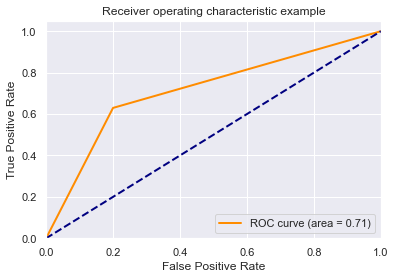

In [19]:
fpr, tpr, thresholds = metrics.roc_curve(y_testt, y_pred)

# Compute ROC curve and ROC area for each class
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Curva de aprendizaje Focal loss

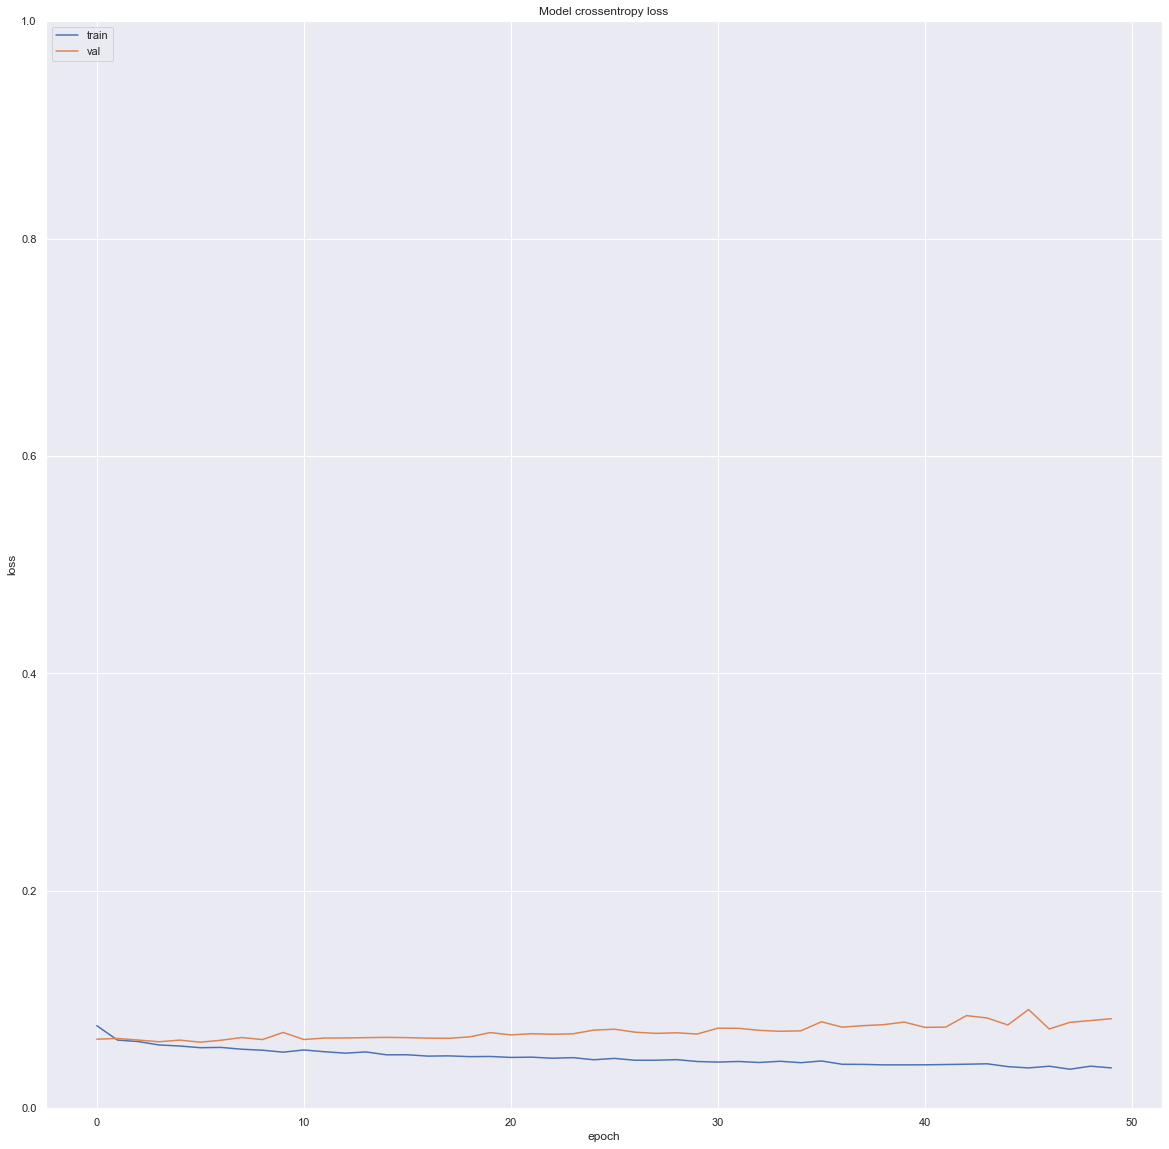

In [20]:
plt.figure(figsize=(20,20))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model crossentropy loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.ylim(0,1)
plt.show()

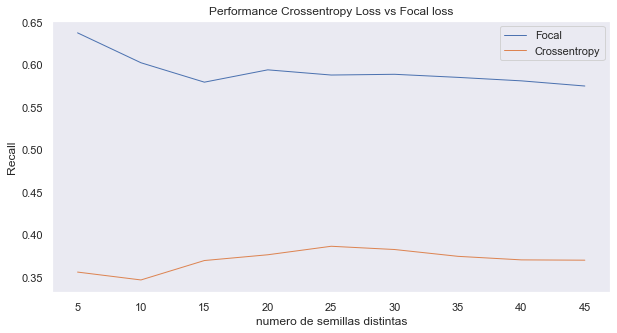

In [40]:
graficar(0.75, 3, diabetes,32)

# Data sintética

Los fines de esta instancia, es intentar obtener un umbral de desbalanceo en el cuál se observe una diferencia en rendimiento entre las 2 pérdidas consideradas en este trabajo. Por un lado tenemos la **Crossentropy Loss** que esperamos tenga nuevamente un comportamiento estable en la métrica de interés considara, para este caso, **Recall**. Por otro lado, tenemos a la **Focal Loss**, la cuál se espera tenga un rendimiento levemente mejor que la crossentropy loss, debido a su agresivo entrenamiento con datos que realmente son relevantes para el problema, evitando trabajar demasiado con datos fáciles de clasificar.

Se consideran las 2 datas presentadas anteriormente, las cuales tendrán la clase minoritaria constante, e iremos desbalanceando los datos agregando ejemplos de la clase mayoritaria. 

<span class="mark">Se considera que el desbalanceo es 0 si ambas clases tienen igual cantidad de ejemplos, mientras que el desbalanceo es $100%$ si la clase mayoritaria cuenta con el doble de ejemplos que la clase minoritaria.</span>

## Data Sintética Diabetes

In [59]:
diabetes = pd.read_csv('diabetes.csv')
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [60]:
porcentaje = 0.5
n_datos =  diabetes[diabetes['Outcome']==1].shape[0] + diabetes[diabetes['Outcome']==1].shape[0]*porcentaje

datos_clase_may = diabetes[diabetes['Outcome']==0][:int(n_datos)]
datos_clase_min = diabetes[diabetes['Outcome']==1]

diabetes_2 = pd.concat([datos_clase_may, datos_clase_min], axis=0)

In [61]:
porcentajes = [0., 0.25, 0.5, 0.75, 1.]
data = pd.DataFrame(columns=['porcentaje', 'recall crossentropy loss', 'acc crossentropy loss','recall focal loss', 'acc focal loss'])
i=0
for porcentaje in porcentajes:
    lis=[]
    #Desbalanceo de clases
    
    n_datos =  diabetes[diabetes['Outcome']==1].shape[0] + diabetes[diabetes['Outcome']==1].shape[0]*porcentaje

    datos_clase_may = diabetes[diabetes['Outcome']==0][:int(n_datos)]
    datos_clase_min = diabetes[diabetes['Outcome']==1]

    diabetes_2 = pd.concat([datos_clase_may, datos_clase_min], axis=0)
    diabetes_2 = diabetes_2.reset_index(drop=True)
    
    
    #Preprocesamiento
    
    X = diabetes_2.drop('Outcome', axis=1)
    y_labels = diabetes_2['Outcome']
    y_lab_cat= pd.get_dummies(y_labels)

    #Division de la data
    x_train, x_test, y_train, y_test, train_ind, test_ind  = train_test_split(X, y_lab_cat, diabetes_2.index ,test_size=0.2, stratify=y_lab_cat, random_state=42)
    
    
    #Escalamiento

    scaler = StandardScaler()
    scaler.fit(x_train)

    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)

    y_train= y_train.to_numpy(dtype=np.float64)

    #modelo crossentropy loss
    
    model1 = ite_model()
 
    model1.compile(optimizer='SGD', loss= 'categorical_crossentropy', metrics=['acc'])

    #Fit
    model1.fit(x_train, y_train, epochs=50, batch_size=32, verbose = 0)

    #predicciones
    y_pred = model1.predict(x_test)
    y_pred = np.argmax(y_pred, axis=1)
    
    #guarda scores crossentropy
    
    lis.append(porcentaje)
    lis.append(recall_score(diabetes_2.loc[list(y_test.index), diabetes_2.columns[-1]], y_pred, average='binary', pos_label= 1))
    lis.append(accuracy_score(diabetes_2.loc[list(y_test.index), diabetes_2.columns[-1]], y_pred, normalize=True))
    #modelo focal loss
    
    model1 = ite_model()
 
    model1.compile(optimizer='SGD', loss=tfa.losses.SigmoidFocalCrossEntropy(alpha= float(0.75), gamma= float(3)), metrics=['acc'])

    #Fit
    model1.fit(x_train, y_train, epochs=50, batch_size=32, verbose = 0)

    #predicciones
    y_pred = model1.predict(x_test)
    y_pred = np.argmax(y_pred, axis=1)
    
    #guarda scores focal loss
    lis.append(recall_score(diabetes_2.loc[list(y_test.index), diabetes_2.columns[-1]], y_pred, average='binary', pos_label= 1))
    lis.append(accuracy_score(diabetes_2.loc[list(y_test.index), diabetes_2.columns[-1]], y_pred, normalize=True))
    
    data.loc[i]= lis
    i+=1

In [62]:
data

,porcentaje,recall crossentropy loss,acc crossentropy loss,recall focal loss,acc focal loss
0,0.00,0.796296,0.777778,0.611111,0.703704
1,0.25,0.703704,0.743802,0.740741,0.719008
2,0.50,0.685185,0.791045,0.685185,0.723881
3,0.75,0.648148,0.770270,0.592593,0.709459
4,1.00,0.592593,0.759740,0.611111,0.766234


In [63]:
dat_rec = data.loc[:, ['porcentaje','recall crossentropy loss', 'recall focal loss']]
dat_acc = data.loc[:, ['porcentaje','acc crossentropy loss', 'acc focal loss']]

### Comparación Recall para distintos porcentajes de desbalanceo

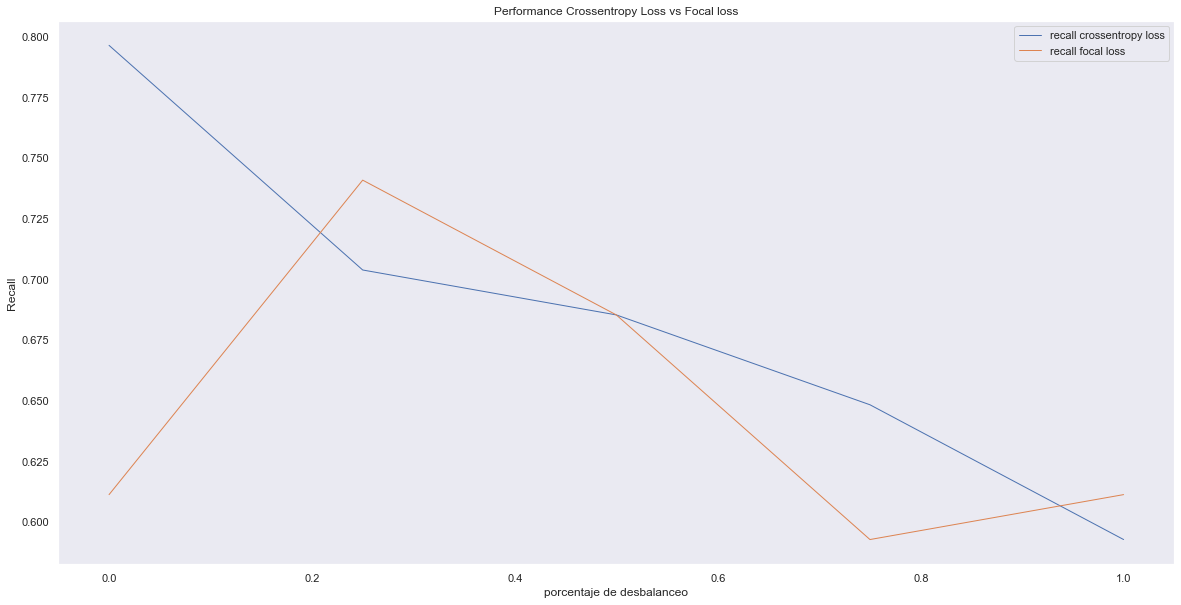

In [64]:
plt.figure(figsize=(20,10))

for i in range(1,3):
    plt.plot(
    dat_rec['porcentaje'],# eje x
    dat_rec.iloc[:,i], # eje y
    label=dat_rec.columns[i], # etiquetado
    linewidth=1 # tamano de la curva
    )

plt.legend() # agregar etiquetado
plt.title("Performance Crossentropy Loss vs Focal loss") # agregar titulo
plt.xlabel("porcentaje de desbalanceo") # nombre eje x
plt.ylabel("Recall") # nombre eje y
plt.grid() # agregar grillado
plt.show() # mostrar grafico



### Comparación Accuracy para distintos porcentajes de desbalanceo

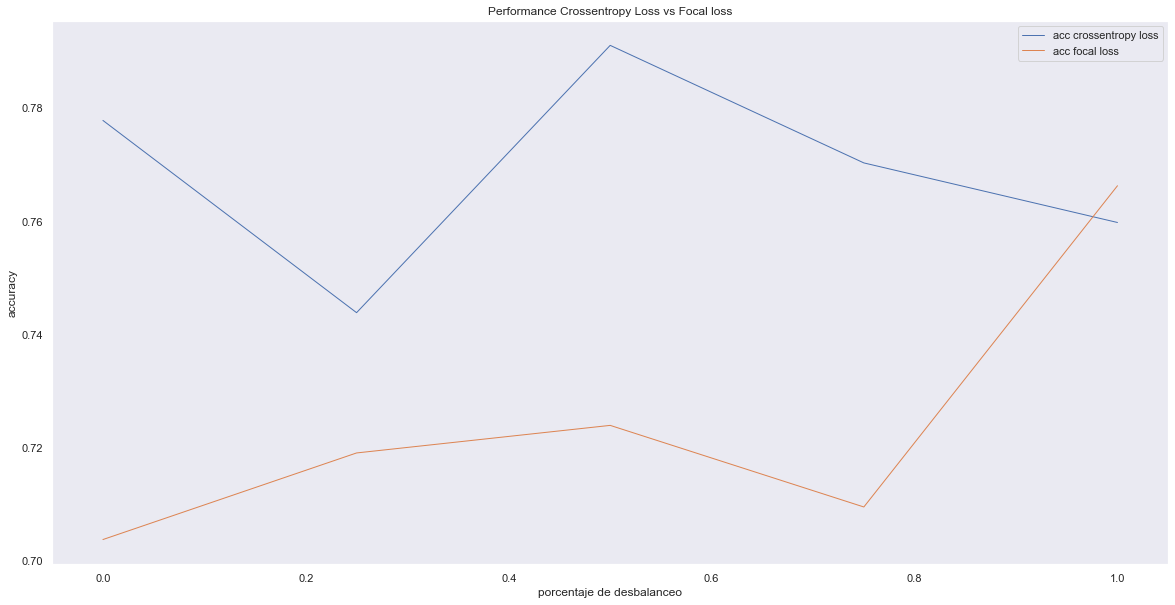

In [65]:
plt.figure(figsize=(20,10))

for i in range(1,3):
    plt.plot(
    dat_acc['porcentaje'],# eje x
    dat_acc.iloc[:,i], # eje y
    label=dat_acc.columns[i], # etiquetado
    linewidth=1 # tamano de la curva
    )

plt.legend() # agregar etiquetado
plt.title("Performance Crossentropy Loss vs Focal loss") # agregar titulo
plt.xlabel("porcentaje de desbalanceo") # nombre eje x
plt.ylabel("accuracy") # nombre eje y
plt.grid() # agregar grillado
plt.show() # mostrar grafico



## Data sintética fraude crediticio 

In [66]:
credit_df= pd.read_csv('creditcard.csv')

In [67]:
print ('real cases:', len(credit_df[credit_df['Class']==0]))
print ('fraud cases: ', len(credit_df[credit_df['Class']==1]))

real cases: 284315
fraud cases:  492


In [69]:
porcentajes = [0., 0.5, 1., 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
data = pd.DataFrame(columns=['porcentaje', 'recall crossentropy loss', 'acc crossentropy loss','recall focal loss', 'acc focal loss'])
i=0

for porcentaje in porcentajes:
    lis=[]
    #Desbalanceo de clases
    
    n_datos =  credit_df[credit_df['Class']==1].shape[0] + credit_df[credit_df['Class']==1].shape[0]*porcentaje

    datos_clase_may = credit_df[credit_df['Class']==0][:int(n_datos)]
    datos_clase_min = credit_df[credit_df['Class']==1]

    credit_df_2 = pd.concat([datos_clase_may, datos_clase_min], axis=0)
    credit_df_2 = credit_df_2.reset_index(drop=True)
    
    #Preprocesamiento
    robust_scaler =RobustScaler()

    credit_df[['Amount']] = robust_scaler.fit_transform(credit_df[['Amount']]) 

    X_labels = credit_df_2.drop(['Class', 'Time'], axis=1)
    y_labels = credit_df_2['Class']
    X_labels = X_labels.to_numpy(dtype=np.float64)
    y_lab_cat= pd.get_dummies(y_labels)

    #y_labels = y_labels.to_numpy(dtype=np.float64)

    #y_lab_cat = tf.keras.utils.to_categorical(y_labels, num_classes=2, dtype='float32')


    x_train, x_test, y_train, y_test, train_ind, test_ind = train_test_split(X_labels, y_lab_cat, credit_df_2.index , test_size=0.3, stratify=y_lab_cat, random_state=42)

    y_train= y_train.to_numpy(dtype=np.float64)

    #modelo crossentropy loss
    
    model1 = ite_model()
 
    model1.compile(optimizer='SGD', loss= 'categorical_crossentropy', metrics=['acc'])

    #Fit
    model1.fit(x_train, y_train, epochs=50, batch_size=256, verbose = 0)

    #predicciones
    y_pred = model1.predict(x_test)
    y_pred = np.argmax(y_pred, axis=1)
    
    #guarda scores crossentropy
    
    lis.append(porcentaje)
    lis.append(recall_score(credit_df_2.loc[list(y_test.index), credit_df_2.columns[-1]], y_pred, average='binary', pos_label= 1))
    lis.append(accuracy_score(credit_df_2.loc[list(y_test.index), credit_df_2.columns[-1]], y_pred, normalize=True))
    #modelo focal loss
    
    model1 = ite_model()
 
    model1.compile(optimizer='SGD', loss=tfa.losses.SigmoidFocalCrossEntropy(alpha= float(0.75), gamma= float(5)), metrics=['acc'])

    #Fit
    model1.fit(x_train, y_train, epochs=50, batch_size=256, verbose = 0)

    #predicciones
    y_pred = model1.predict(x_test)
    y_pred = np.argmax(y_pred, axis=1)
    
    #guarda scores focal loss
    lis.append(recall_score(credit_df_2.loc[list(y_test.index), credit_df_2.columns[-1]], y_pred, average='binary', pos_label= 1))
    lis.append(accuracy_score(credit_df_2.loc[list(y_test.index), credit_df_2.columns[-1]], y_pred, normalize=True))
    
    data.loc[i]= lis
    i+=1

In [ ]:
data

In [70]:
dat_rec = data.loc[:, ['porcentaje','recall crossentropy loss', 'recall focal loss']]
dat_acc = data.loc[:, ['porcentaje','acc crossentropy loss', 'acc focal loss']]

### Comparación Recall para distintos porcentajes de desbalanceo

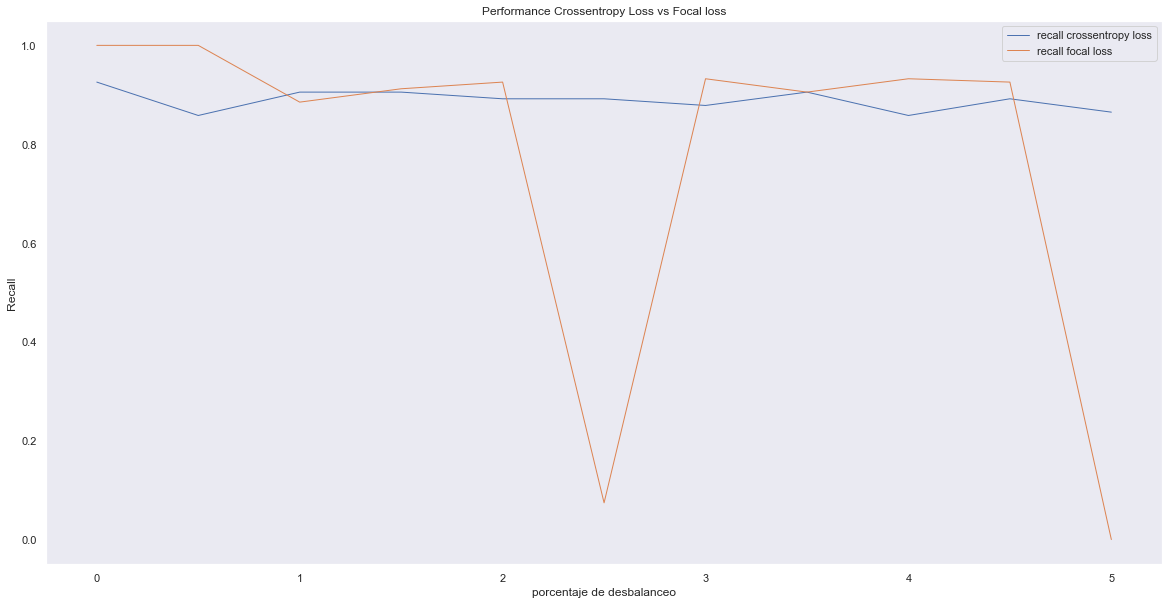

In [71]:
plt.figure(figsize=(20,10))

for i in range(1,3):
    plt.plot(
    dat_rec['porcentaje'],# eje x
    dat_rec.iloc[:,i], # eje y
    label=dat_rec.columns[i], # etiquetado
    linewidth=1 # tamano de la curva
    )

plt.legend() # agregar etiquetado
plt.title("Performance Crossentropy Loss vs Focal loss") # agregar titulo
plt.xlabel("porcentaje de desbalanceo") # nombre eje x
plt.ylabel("Recall") # nombre eje y
plt.grid() # agregar grillado
plt.show() # mostrar grafico


### Comparación Accuracy para dintintos porcentajes de desbalanceo

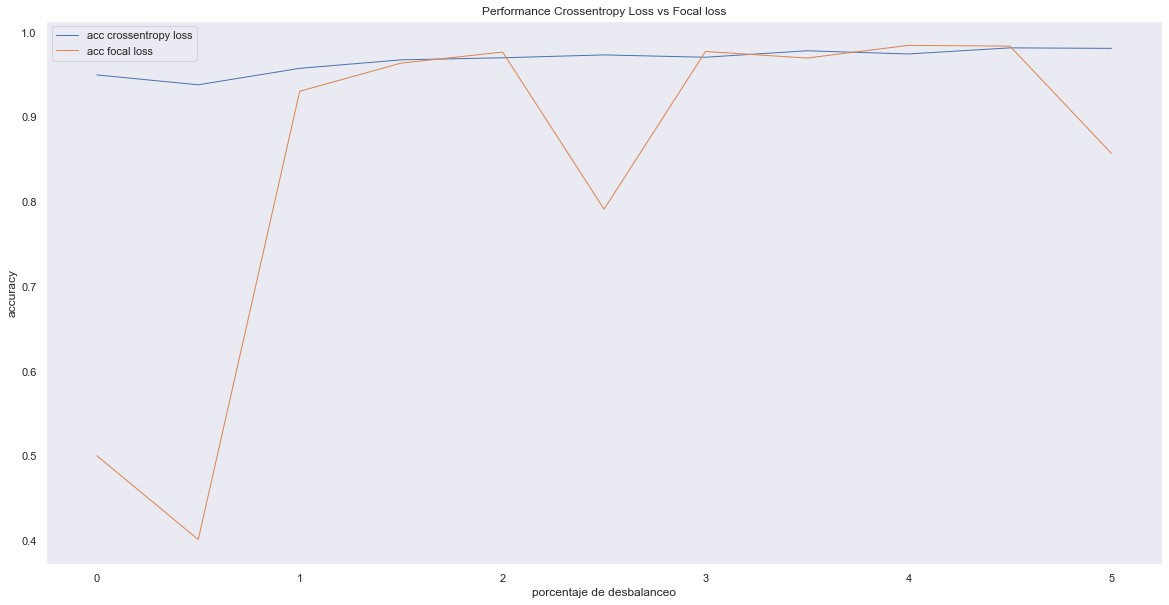

In [72]:
plt.figure(figsize=(20,10))

for i in range(1,3):
    plt.plot(
    dat_acc['porcentaje'],# eje x
    dat_acc.iloc[:,i], # eje y
    label=dat_acc.columns[i], # etiquetado
    linewidth=1 # tamano de la curva
    )

plt.legend() # agregar etiquetado
plt.title("Performance Crossentropy Loss vs Focal loss") # agregar titulo
plt.xlabel("porcentaje de desbalanceo") # nombre eje x
plt.ylabel("accuracy") # nombre eje y
plt.grid() # agregar grillado
plt.show() # mostrar grafico


# Conclusiones

Dentro de las conclusiones extraídas de este trabajo se desprenden las siguientes.

> Es esperable que el entrenamiento del modelo usando **Focal Loss** mejore los resultados en problemas de clasificación con datos desbalanceados. Esto quedo evienciado en los gráficos generados para los problemas desbalanceados propuestos en este trabajo. En particular, la métrica de interés en este trabajo es el recall, pues se considera más riesgoso en problemas desbalanceados, realizar una predicción errónea sobre la clase minoritaria, que hacer una buena predicción sobre la <span class="mark">clase balanceada</span>. Es por este motivo que accuracy no es una métrica representativa para este problema
$$Recall = \dfrac{tp}{tp+fn}$$ Dónde el $Recall$ mide la proporción entre todas las veces que era realmente la clase de interés, versus cuantas predijo el modelo correctamente.



 ¿Por qué Focal Loss resulta tener mejores resultados que Crossentropy Loss?. 

> En efecto, Focal Loss enfoca su entrenamiento en los ejemplos problemáticos o dificiles de clasificar, en este caso los de la clase minoritaria. Por lo que cuando el problema presenta un desbalanceo de alrededor del 40% de una clase con respecto a la otra, es <span class="mark">conveniente utilizar Focal Loss</span>. Mientras que para problemas con un desbalanceo menor que 40%, **Crossentropy Loss** ofrece resultados más estables en las métricas de interés. 

¿Existe alguna desventaja al utilizar Focal Loss?

> Experimentalmente, se concluye que si bien focal loss presenta mejoras en los resultados de la clasificación, este tipo de pérdidas al tener un entrenamiento tan agresivo con los ejemplos que considera fáciles de clasificar, es muy sensible a los datos y la semilla. Debido a esto se observan en los gráficos que los resultados para la **Crossentropy Loss** son rectas más estables para diferentes instancias, mientras que para la **Focal Loss** tenemos saltos muy repentinos en los scores. Es por esto que metodologicamente es importante utilizar muchas semillas y obtener un score promedio, pues de es ta forma podremos visualizar cuál es el resultado que esperamos tener para cada pérdida utilizada. Es decir, para muchas semillas se espera que **Focal Loss** estabilice su score en un valor promedio mayor que el de la **Crossentropy Loss**. Mientras que para una instancia en particular (semilla aleatoria), <span class="mark">**Crossentropy Loss** ofrece un resultado más estable independiente de la semilla utilizada.</span>
